## Welvaart heeft de grootste invloed op misdaad

Volgens De Courson & Nettle (2021) is voor mensen met een laag inkomen en kapitaal de criminaliteit de beste manier om hun kwaliteit van leven te verbeteren. Hoewel er het risico is om gepakt te worden, is de mogelijke winst bij succes dit risico waard. Vanwege het kleine toekomstperspectief is misdaad voor deze bevolkingsgroep de beste kans om hun leven te verbeteren. Volgens ditzelfde onderzoek leidt een grote ongelijkheid tot meer criminaliteit, terwijl een eerlijkere verdeling van welvaart positieve effecten heeft en de mogelijke voordelen van misdaad verkleint. Daarom is het eerlijk verdelen van de welvaart van een land de meest effectieve manier om criminaliteit in een land te verminderen, aldus dit perspectief.

### Verband tussen welvaart en verschillende misdaden

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.io as pio

pio.renderers.default = 'notebook'

# === Load Data ===

# Crime dataset
crime_df = pd.read_csv("europe_crime_definitive_per_100k.csv")


# World Bank economic dataset
econ_df = pd.read_csv("world_bank_definitive.csv")

# === Filter and Preprocess ===

# Desired economic indicators
selected_indicators = [
"GDP, PPP (constant 2021 international $)",
"Gross national expenditure (current US$)",
"Imports of goods and services (current US$)",
"Total reserves (includes gold, current US$)",
"GNI per capita growth (annual %)",
"Inflation, consumer prices (annual %)"
]

# Filter econ_df for selected indicators
econ_filtered = econ_df[econ_df["Indicator Name"].isin(selected_indicators)]

# Pivot so each indicator becomes a column
econ_pivot = econ_filtered.pivot_table(
index=["Country Name", "Year"],
columns="Indicator Name",
values="Value"
).reset_index()

# Prepare crime data
crime_df['Year'] = pd.to_numeric(crime_df['Year'], errors='coerce')

# Rename columns for convenience
econ_pivot.columns.name = None

# Merge on Country and Year
merged_df = pd.merge(econ_pivot, crime_df, on=['Country Name', 'Year'])

# Drop rows with missing values
merged_df.dropna(inplace=True)

# Extract actual column names
econ_cols = selected_indicators
crime_cols = [col for col in crime_df.columns if col not in ['Country Name', 'Year'] and col in merged_df.columns]

# Subset relevant columns
corr_data = merged_df[econ_cols + crime_cols].select_dtypes(include=[np.number])

# Recalculate available econ and crime columns (since some might have been dropped)
econ_cols_numeric = [col for col in econ_cols if col in corr_data.columns]
crime_cols_numeric = [col for col in crime_cols if col in corr_data.columns]

# Compute correlation matrix
correlation_matrix = corr_data.corr()
econ_crime_corr = correlation_matrix.loc[econ_cols_numeric, crime_cols_numeric]

# === Plot Heatmap ===
fig = px.imshow(
econ_crime_corr,
labels=dict(x="Misdaad Indicators", y="Economische Indicators", color="Correlatie"),
x=econ_crime_corr.columns,
y=econ_crime_corr.index,
color_continuous_scale="RdBu",
zmin=-1, zmax=1,
)
fig.update_layout(title="Correlatie tussen Economische indicators en misdaad indicators")
fig.show()

> *Figuur 1: Een heatmap met correlatie scores tussen economische- en misdaadsvariabelen. De economische variabelen "GDP, PPP (constant 2021 international \$)", "Gross national expenditure (current US\$)" en "Import of goods and services (current US\$)" vertonen een postieve correlatie van +/- 0.72 met de misdaadcategorieën "Fraud" en "Kidnapping". Ze vertonen ook een positieve correlatie van +/- 0.53 met "Sexual Assault". "Total reserves (includes gold, current US\$) vertoont een positieve correlatie van 0.686 met "Unlawful acts involving controlled drugs or precursors".*

## Nalezen. Correlatie vanaf 0.5 is 'lichte correlatie', meer dan 0.7 is significant

In figuur 1 zijn meerdere correlaties te zien tussen geselecteerde economische factoren en misdaad cijfers (per 100.000 inwoners). In deze figuur is er een duidelijke correlatie tussen 3 economische factoren, en 2 soorten misdaad. GDP, PPP (constant 2021 international \$), gross national expenditure (current US\$) en import of goods and services (current US \$) vertonen een positieve correlatie met fraude en kidnapping. Deze drie economische variabelen vormen samen een indicator voor de welvaart van een land. Dit houdt in dat fraude en kidnapping volgens deze heatmap vaker voor komen in welvarende landen dan in minder welvarende landen. 

Sexual assault vertoont ook een positieve correlatie met de welvaart van een land. Het lijkt ons niet waarschijnlijk dat een welvarende bevolking meer geneigd is tot seksueel geweld dan een minder welvarende. Een mogelijke alternatieve verklaring is dat in welvarende landen een groter deel van gepleegde misdaden gerapporteerd wordt.

## Iets over de correlatie met drugs

Het gebrek aan significante correlatie tussen 'toegankelijke' misdaden zoals 'theft' en 'robbery' en een economische indicator is verassend. Vanuit het perspectief dat economische druk mensen richting criminaliteit duwt, zou men verwachten een correlatie met bijvoorbeeld inflatie te zien. Dit zou wederom kunnen liggen aan de manier van data verzamelen (alleen gerapporteerde, 'gepakte' misdaden worden geteld), maar het kan ook zijn dat factoren als werkloosheid en vertrouwen in de rechtsstaat een grotere rol spelen.

### Geen verband tussen hoeveelheid politieagenten en aantal misdaden

In [2]:
import pandas as pd
import plotly.graph_objects as go

# Load data (simplified version)
police_df = pd.read_csv("europe_justice_per_100k.csv")
crime_df = pd.read_csv("europe_crime_definitive_per_100k.csv")
crime_df["Total Crime Rate per 100k"] = crime_df.iloc[:, 3:].sum(axis=1)

merged_df = pd.merge(
    police_df[["geo", "Year", "Police officers"]],
    crime_df[["geo", "Year", "Total Crime Rate per 100k"]],
    on=["geo", "Year"]
)
merged_df.dropna(inplace=True)

# Selected countries for example purposes
countries = ["BE", "CY", "DE", "DK", "FR", "HU", "MT", "PT", "SE", "SK"]

### All countries in the dataset
### countries = sorted(merged_df["geo"].unique())

# Build figure
fig = go.Figure()
for country in countries:
    data = merged_df[merged_df["geo"] == country]
    fig.add_trace(go.Scatter(x=data["Year"], y=data["Police officers"], name=f"{country} - Police", visible=(country=="AL")))
    fig.add_trace(go.Scatter(x=data["Year"], y=data["Total Crime Rate per 100k"], name=f"{country} - Crime", visible=(country=="AL")))

# Dropdown menu
dropdowns = []
for i, country in enumerate(countries):
    vis = [False] * len(countries) * 2
    vis[i*2] = True
    vis[i*2+1] = True
    dropdowns.append(dict(label=country, method="update", args=[{"visible": vis}]))

fig.update_layout(updatemenus=[dict(buttons=dropdowns)], title="Police and Crime Rate",
                  xaxis_title='Year',
                  yaxis_title='Amount per 100k inhabitants',
                  height=600)

# Show inside notebook
fig.show()

> *Figuur 2: Een lijn grafiek die de hoeveelheid politieagenten en de hoeveelheid diefstallen per 100.000 inwoners per jaar vergelijkt. Er is een menu om de gegevens van verschillende landen te selecteren. Niet alle landen uit de dataset zijn weergegeven voor overzichtelijkheid en vanwege sommige missende gegevens.*

De grafiek toont de ontwikkeling van het aantal politieagenten en het aantal geregistreerde diefstallen per land over meerdere jaren. Wat opvalt, is dat er geen correlatie lijkt te zijn in de trends van het aantal politieagenten en het aantal diefstallen. In sommige landen daalt het aantal diefstallen ondanks een afname van het politieapparaat, terwijl in andere landen een stijging van het aantal agenten samengaat met meer meldingen van diefstal. Dit suggereert dat andere factoren zoals sociale omstandigheden, wetgeving, meldingsbereidheid en economische situatie een grotere rol spelen in de criminaliteitscijfers dan handhaving alleen. Deze figuur benadrukt dat het aantal politieagenten op zichzelf geen garantie is voor minder criminaliteit, maar slechts één van de meerdere beïnvloedende factoren, en spreekt hiermee het tweede perspectief tegen.

### Meer ongelijkheid... minder misdaden?

Volgens het eerste perspectief is economische ongelijkheid een belangrijke factor in het bestrijden van criminaliteit. Als een (groot) deel van de bevolking van een land in armoede leeft terwijl een ander deel de welvaart voor zichzelf houdt, zal het arme deel sneller geneigd zijn tot misdaad dan wanneer de welvaart eerlijk over het land is verdeeld.

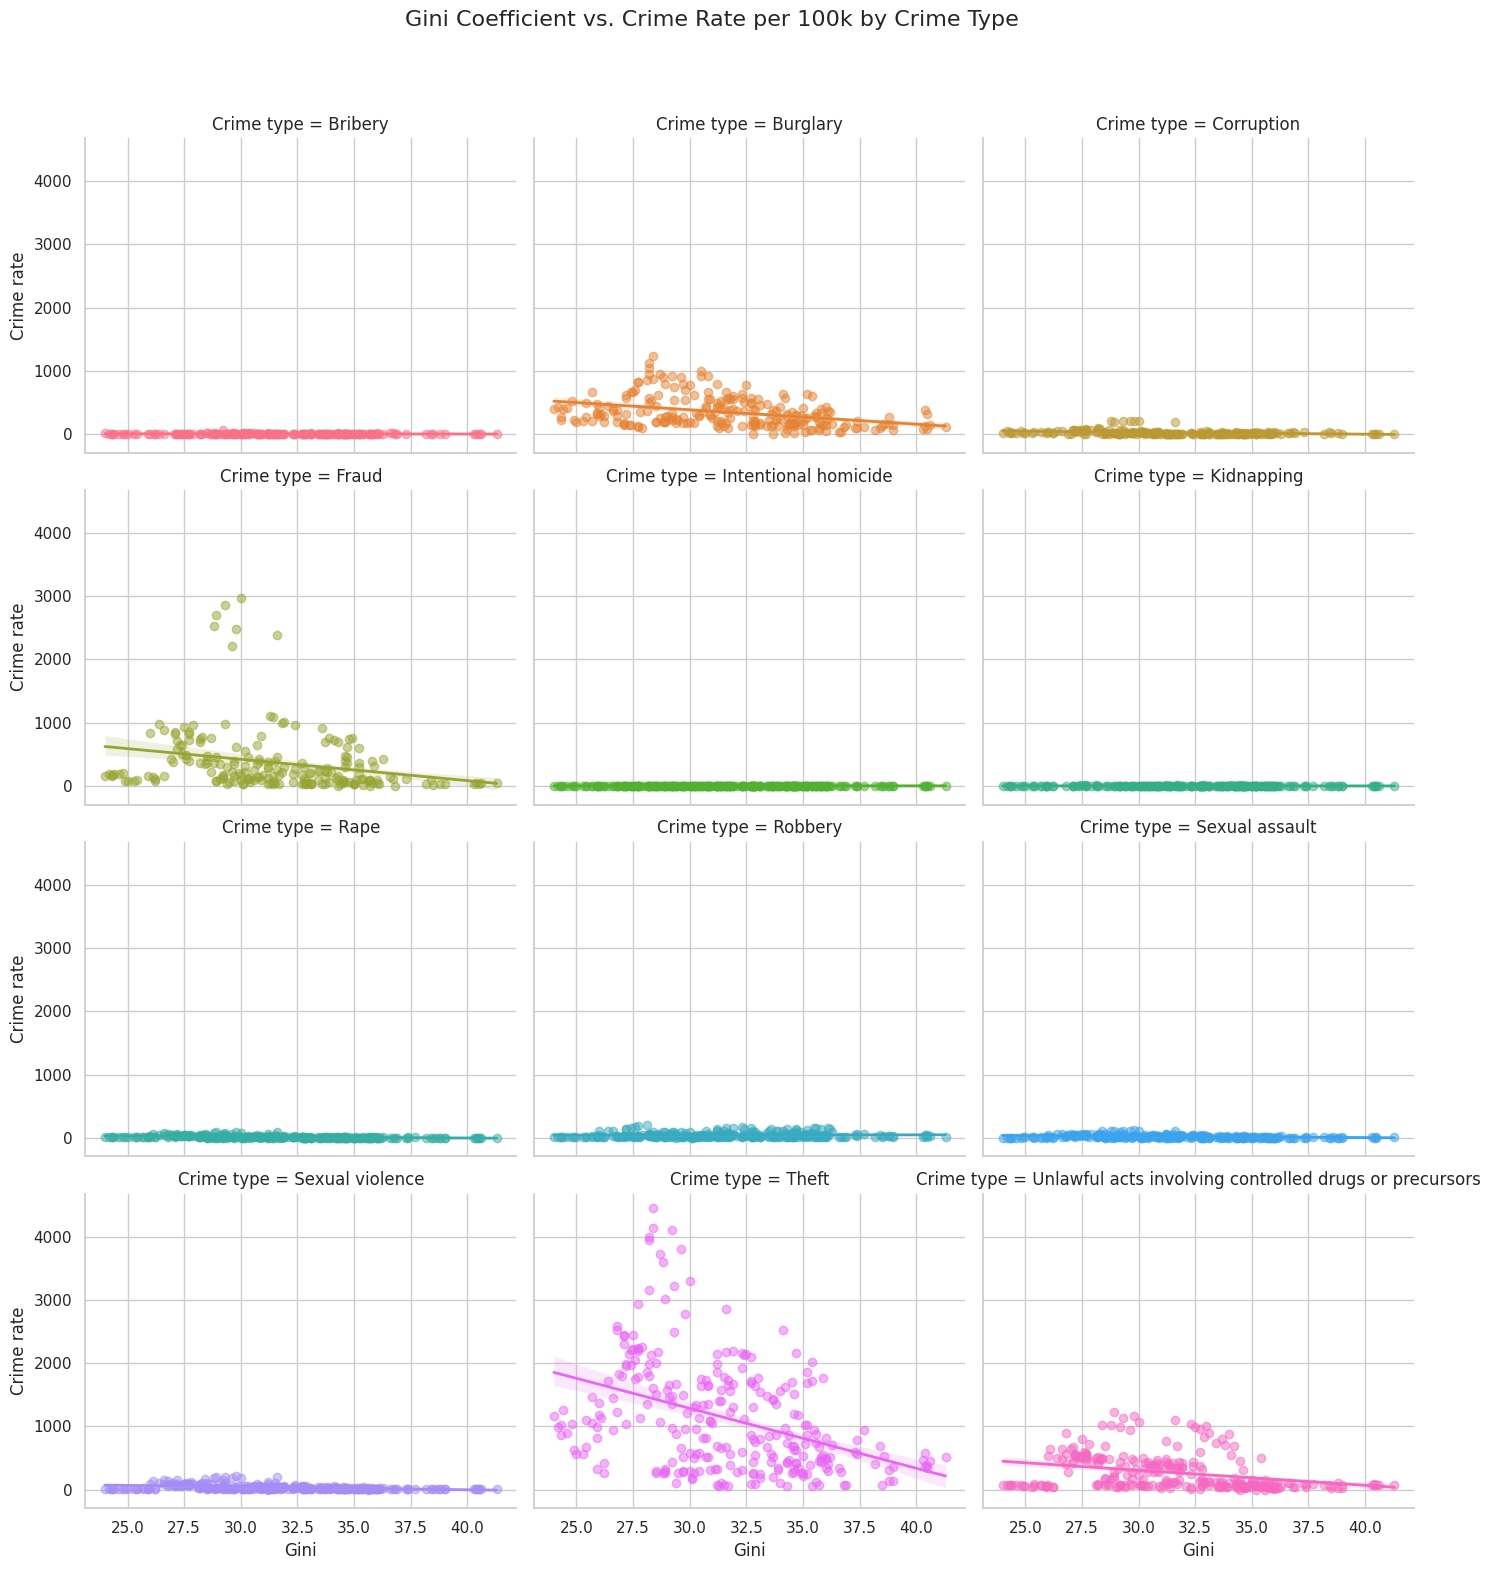

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio

pio.renderers.default = 'notebook'

# Load the crime dataset (wide format)
crime_df = pd.read_csv("europe_crime_definitive_per_100k.csv")

# Load the Gini coefficient dataset
gini_df = pd.read_csv("gini_definitive.csv")

# Keep only relevant columns from Gini dataset and rename for clarity
gini_df = gini_df.rename(columns={
    "Country Name": "Country",
    "Value": "Gini"
})[["Country", "Year", "Gini"]]

# Reshape crime dataset from wide to long format
crime_long = crime_df.melt(
    id_vars=["Country Name", "geo", "Year"],
    var_name="Crime type",
    value_name="Crime rate"
)

# Rename to match Gini df for merging
crime_long = crime_long.rename(columns={"Country Name": "Country"})

# Merge on Country and Year
merged_df = pd.merge(crime_long, gini_df, on=["Country", "Year"], how="inner")

# Drop rows with missing data
merged_df = merged_df.dropna(subset=["Gini", "Crime rate"])

# Filter out non-numeric or clearly invalid values if necessary
merged_df = merged_df[pd.to_numeric(merged_df["Crime rate"], errors="coerce").notnull()]

# Plot: Regression with confidence intervals for each crime type
sns.set(style="whitegrid")
g = sns.lmplot(
    data=merged_df,
    x="Gini",
    y="Crime rate",
    hue="Crime type",
    col="Crime type",
    col_wrap=3,
    height=4,
    aspect=1.2,
    scatter_kws={"alpha": 0.5},
    line_kws={"linewidth": 2}
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Gini Coefficient vs. Crime Rate per 100k by Crime Type", fontsize=16)

plt.show()


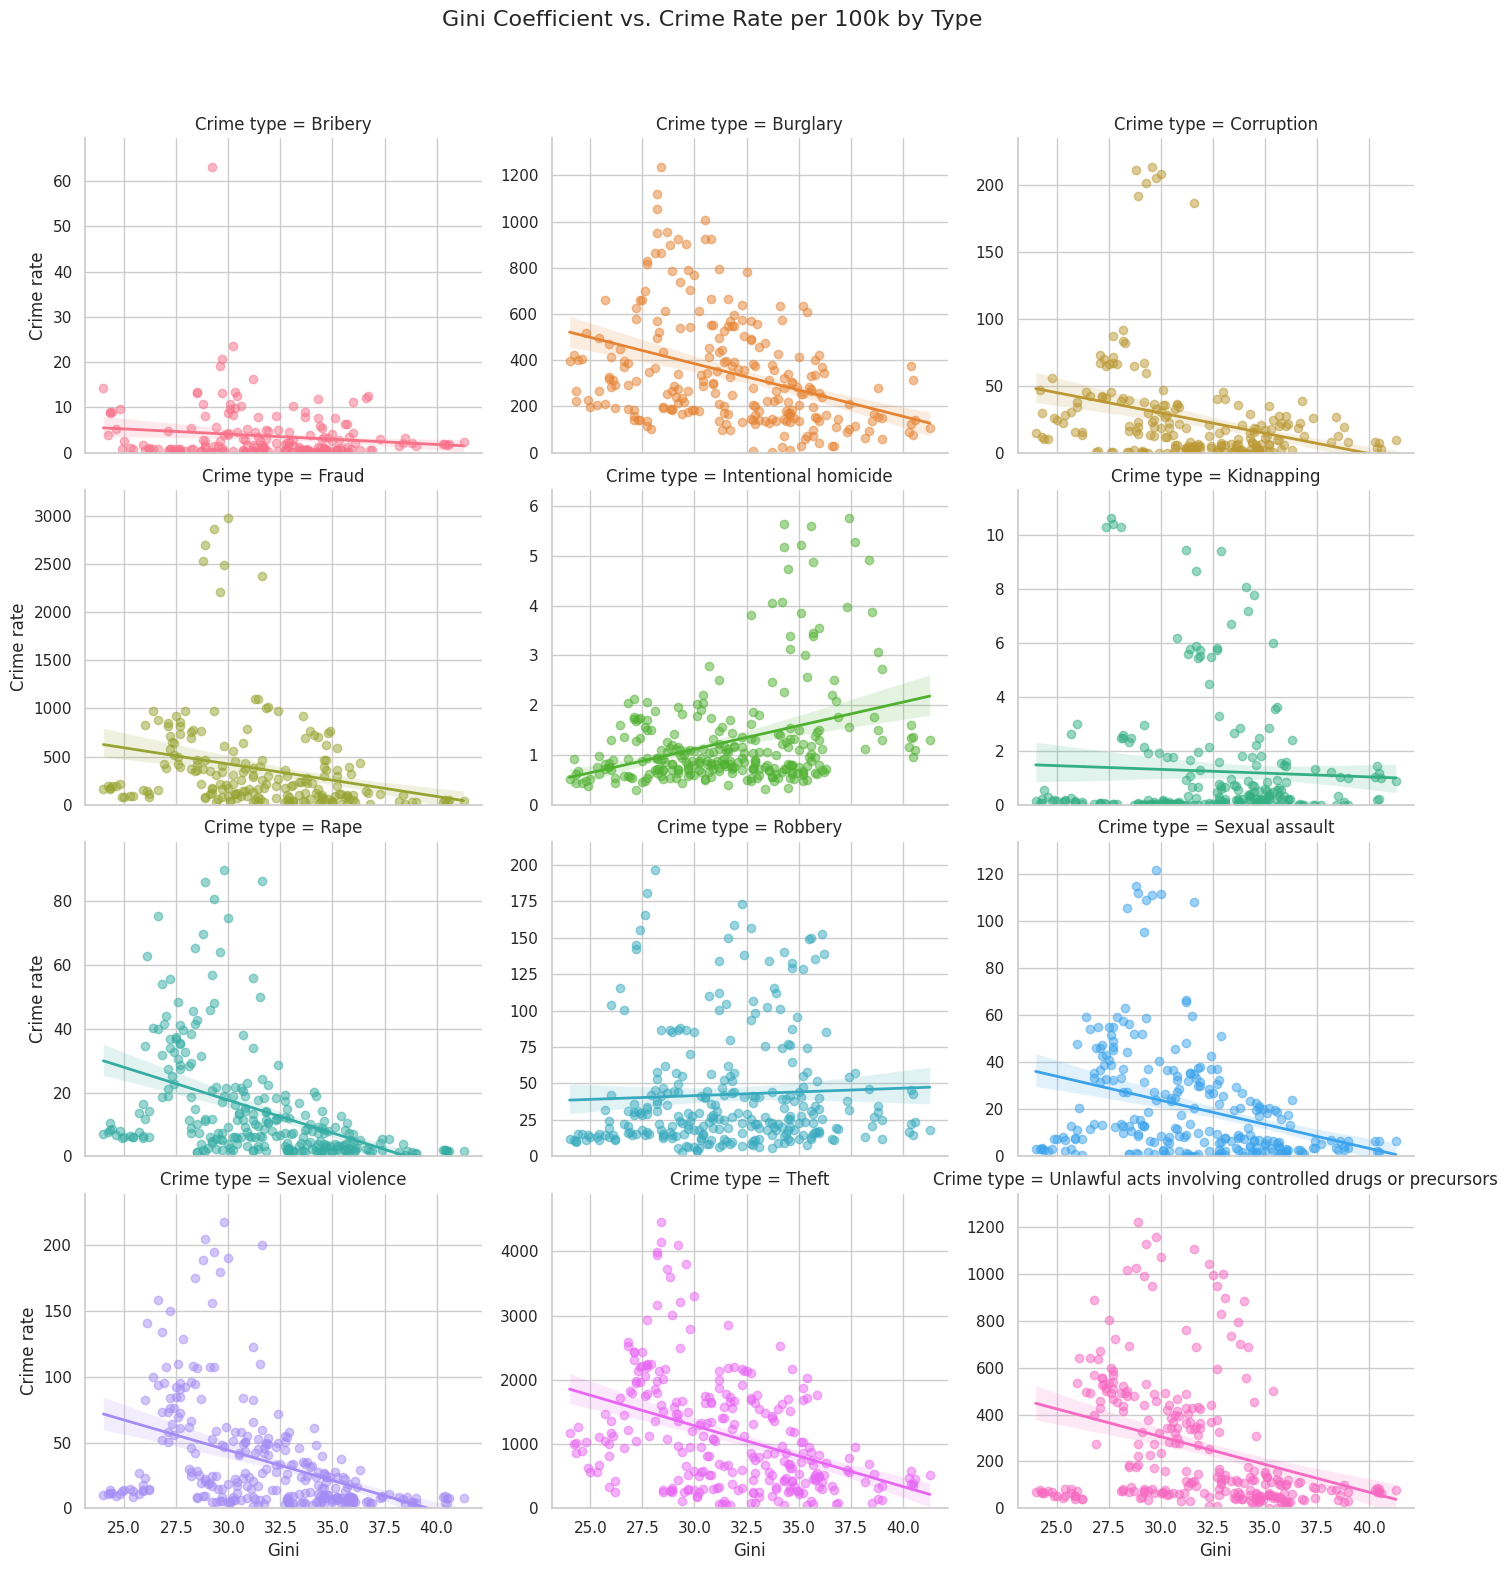

In [4]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio

pio.renderers.default = 'notebook'

# Load the crime dataset (wide format)
crime_df = pd.read_csv("europe_crime_definitive_per_100k.csv")

# Load the Gini coefficient dataset
gini_df = pd.read_csv("gini_definitive.csv")

# Keep only relevant columns from Gini dataset and rename for clarity
gini_df = gini_df.rename(columns={
    "Country Name": "Country",
    "Value": "Gini"
})[["Country", "Year", "Gini"]]

# Reshape crime dataset from wide to long format
crime_long = crime_df.melt(
    id_vars=["Country Name", "geo", "Year"],
    var_name="Crime type",
    value_name="Crime rate"
)

# Rename to match Gini df for merging
crime_long = crime_long.rename(columns={"Country Name": "Country"})

# Merge on Country and Year
merged_df = pd.merge(crime_long, gini_df, on=["Country", "Year"], how="inner")

# Drop rows with missing data
merged_df = merged_df.dropna(subset=["Gini", "Crime rate"])

# Filter out non-numeric or clearly invalid values if necessary
merged_df = merged_df[pd.to_numeric(merged_df["Crime rate"], errors="coerce").notnull()]
merged_df["Crime rate"] = merged_df["Crime rate"].astype(float)

# Plot: Regression with confidence intervals for each crime type
sns.set(style="whitegrid")
g = sns.lmplot(
    data=merged_df,
    x="Gini",
    y="Crime rate",
    hue="Crime type",
    col="Crime type",
    col_wrap=3,
    height=4,
    aspect=1.2,
    scatter_kws={"alpha": 0.5},
    line_kws={"linewidth": 2},
    facet_kws={"sharey": False}  # Important: allow each subplot to have its own y-axis
)

# Set individual y-axis limits per subplot
for ax, crime_type in zip(g.axes.flat, merged_df["Crime type"].unique()):
    max_y = merged_df[merged_df["Crime type"] == crime_type]["Crime rate"].max()
    ax.set_ylim(0, max_y * 1.1)  # Add 10% padding

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Gini Coefficient vs. Crime Rate per 100k by Type", fontsize=16)

plt.show()


> *Figuur 3: Twee verzamelingen van scatterplots, de eerste op dezelfde schaal en de andere met verschillende schalen op de y-as om het verband duidelijker te maken. Van de verschillende categorieën misdaad zijn de gevallen per 100.000 inwoners getekend tegen de Gini-coëfficient van datzelfde jaar. De categorieën burglary, corruption, fraud, rape, sexual violence, theft, en drugs-gerelateerde misdaden vertonen een negatieve trend naarmate de Gini-coëfficient groeit. De categorieën robbery en sexual assault hebben een horizontale trend. De categorieën intentional homocide toont een positieve trend.*

In figuur 3 zien we dat de meeste categorieën misdaden lijken af te nemen naarmate de Gini-coëfficient, en daarmee de inkomstongelijkheid, toeneemt. Dit komt niet overeen met perspectief 1. Wat we op basis van dit perspectief zouden verwachten, is dat naarmate de ongelijkheid toeneemt, er ook meer misdaden worden gepleegd. 